# Training Analysis

In [19]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## From Scratch

### Regular CNN

#### 4 classes

##### Learning Rate

(1e-08, 0.1, 1.0, 3.0)

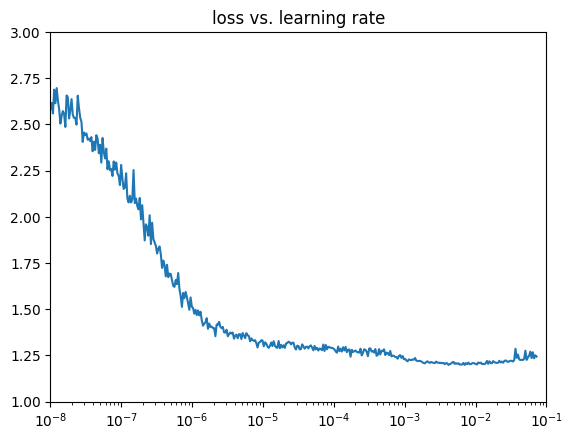

In [6]:
path_to_lr_history = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/numpy_histories/cutout/conv/history_00.npy")

history = np.load(path_to_lr_history, allow_pickle=True).item()

plt.semilogx(history["lr"], history["loss"])
plt.title("loss vs. learning rate")
plt.axis([1e-8, 1e-1, 1, 3])

While this graph isn't perfect, we can see that the loss gradually becomes less when the the learning rate is increased until roughly 10^-5. For the training I then used a lerning rate of 10^-6.

Note: I'll test once more time with 10^-3 (10.08.2024)

##### Training results

dict_keys(['loss', 'root_mean_squared_error', 'accuracy', 'val_loss', 'val_root_mean_squared_error', 'val_accuracy'])


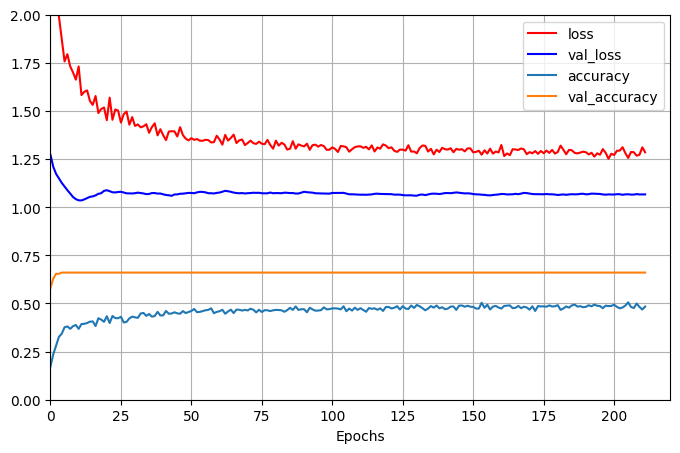

In [27]:
path_to_lr_history = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/training_histories/cutout/conv/convlr00_4_classes_run_2024_08_07_20_42_08/history.npy")

history = np.load(path_to_lr_history, allow_pickle=True).item()

print(history.keys())

pd.DataFrame(history)[["loss","val_loss", "accuracy","val_accuracy"]].plot(figsize=(8,5),
                           xlim=(0,220),
                           ylim=(0,2),
                           grid=True,
                           xlabel="Epochs",
                           style=["r-","b-"],)
plt.show()

dict_keys(['loss', 'root_mean_squared_error', 'accuracy', 'val_loss', 'val_root_mean_squared_error', 'val_accuracy'])


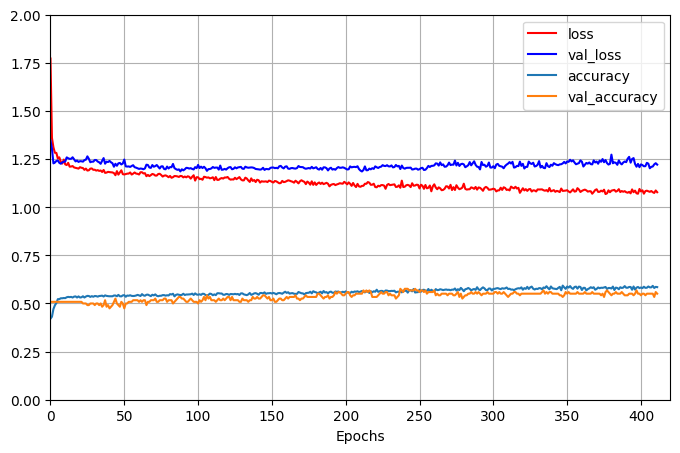

In [30]:
path_to_lr_history = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/training_histories/cutout/conv/conv_00_4_classes_run_2024_08_10_20_49_40/history.npy")

history = np.load(path_to_lr_history, allow_pickle=True).item()

print(history.keys())

pd.DataFrame(history)[["loss","val_loss", "accuracy","val_accuracy"]].plot(figsize=(8,5),
                           xlim=(0,420), #nice
                           ylim=(0,2),
                           grid=True,
                           xlabel="Epochs",
                           style=["r-","b-"],)
plt.show()

### ResNet34 architecture

(1e-08, 0.1, 1.0, 3.0)

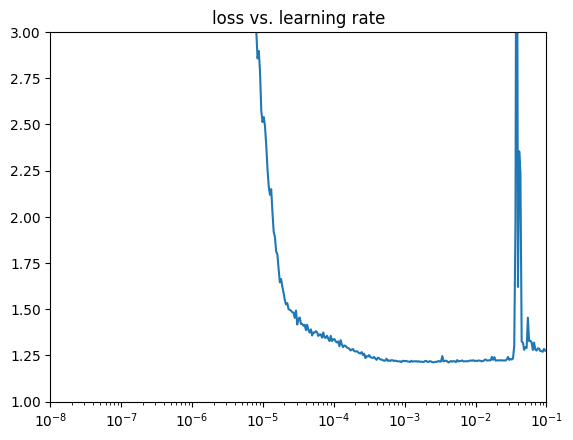

In [4]:
path_to_lr_history = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/numpy_histories/cutout/Resnet34/resnet34lr00_4_classes_run_2024_08_07_21_03_41/history.npy")

history = np.load(path_to_lr_history, allow_pickle=True).item()

plt.semilogx(history["lr"], history["loss"])
plt.title("loss vs. learning rate")
plt.axis([1e-8, 1e-1, 1, 3])

I guess I'll be using a learning rate of roughly 10^-4

Note: one more time with 10^-3

##### Learning rate 10^-4

dict_keys(['loss', 'root_mean_squared_error', 'accuracy', 'val_loss', 'val_root_mean_squared_error', 'val_accuracy'])


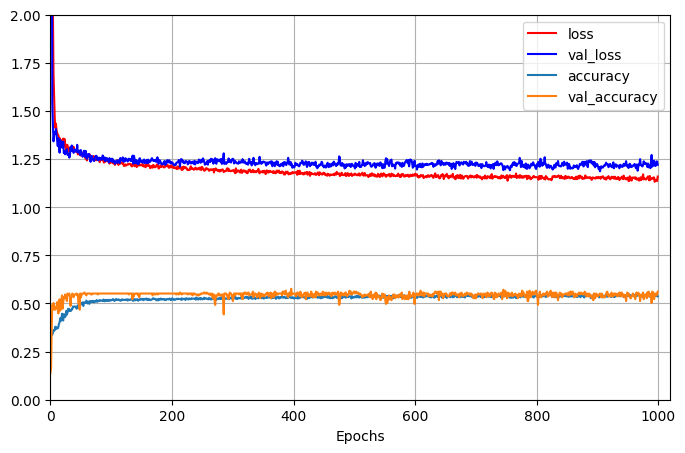

In [33]:
path_to_train_history = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/training_histories/cutout/Resnet34/resnet34lr00_4_classes_run_2024_08_09_08_00_42/history.npy")

history = np.load(path_to_train_history, allow_pickle=True).item()

print(history.keys())

pd.DataFrame(history)[["loss","val_loss", "accuracy","val_accuracy"]].plot(figsize=(8,5),
                           xlim=(0,1020),
                           ylim=(0,2),
                           grid=True,
                           xlabel="Epochs",
                           style=["r-","b-"],)
plt.show()

##### Learning rate 10^-3

dict_keys(['loss', 'root_mean_squared_error', 'accuracy', 'val_loss', 'val_root_mean_squared_error', 'val_accuracy'])


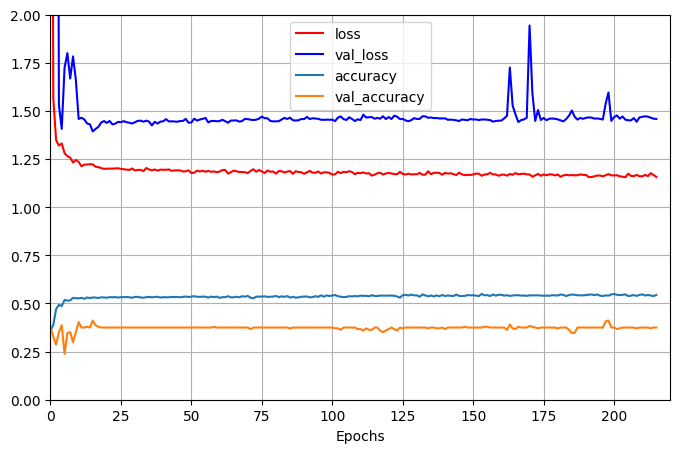

In [32]:
path_to_train_history = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/training_histories/cutout/ResNet34/resnet34_01_4_classes_run_2024_08_10_21_34_49/history.npy")

history = np.load(path_to_train_history, allow_pickle=True).item()

print(history.keys())

pd.DataFrame(history)[["loss","val_loss", "accuracy","val_accuracy"]].plot(figsize=(8,5),
                           xlim=(0,220),
                           ylim=(0,2),
                           grid=True,
                           xlabel="Epochs",
                           style=["r-","b-"],)
plt.show()

yeah that doesn't look that good, the learning rate of 10^-4 seemed to be better suited tbh

### Resnet152 architecture

(1e-08, 0.1, 1.0, 3.0)

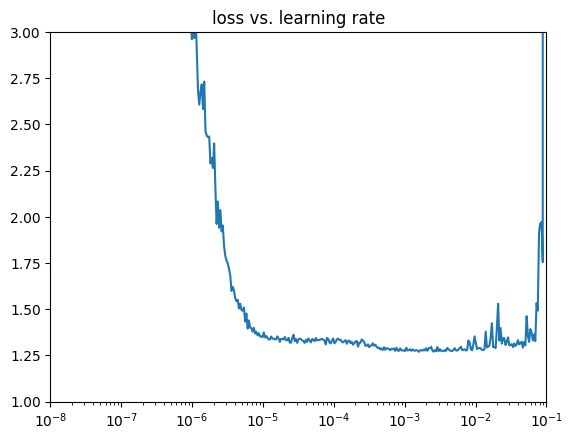

In [13]:
path_to_lr_history = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/training_histories/cutout/Resnet152/resnet152lr00_4_classes_run_2024_08_09_20_14_37/history.npy")

history = np.load(path_to_lr_history, allow_pickle=True).item()

plt.semilogx(history["lr"], history["loss"])
plt.title("loss vs. learning rate")
plt.axis([1e-8, 1e-1, 1, 3])

I chose 10^-3

dict_keys(['loss', 'root_mean_squared_error', 'accuracy', 'val_loss', 'val_root_mean_squared_error', 'val_accuracy'])


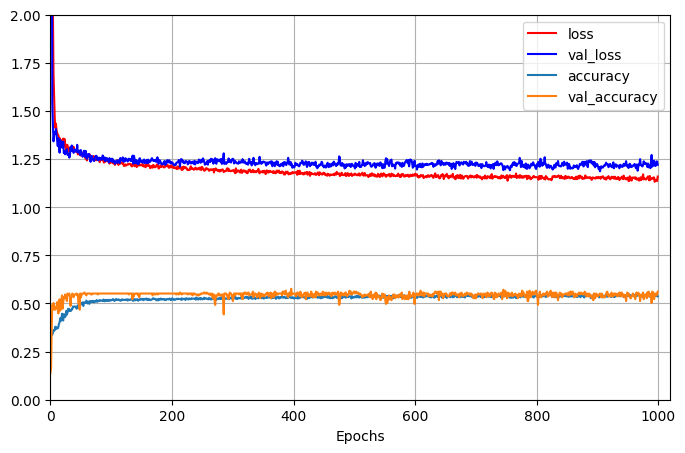

In [40]:
path_to_lr_history = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/training_histories/cutout/ResNet152/resnet152_00_4_classes_run_2024_08_10_22_15_17/history.npy")

history = np.load(path_to_train_history, allow_pickle=True).item()

print(history.keys())

pd.DataFrame(history)[["loss","val_loss", "accuracy","val_accuracy"]].plot(figsize=(8,5),
                           xlim=(0,1020),
                           ylim=(0,2),
                           grid=True,
                           xlabel="Epochs",
                           style=["r-","b-"],)
plt.show()

### ResNeXt50 architecture

(1e-08, 0.1, 1.0, 3.0)

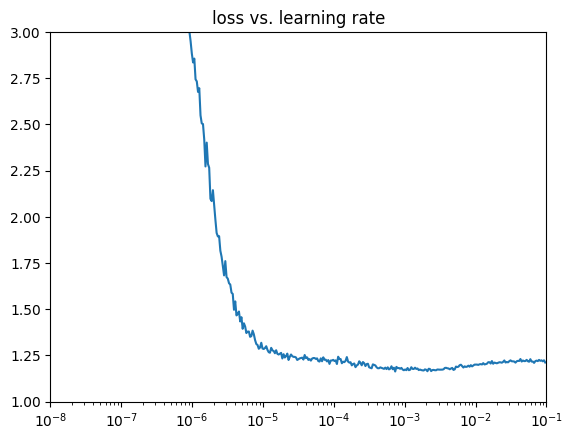

In [43]:
path_to_lr_history = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/training_histories/cutout/ResNeXt50/resnext50lr00_4_classes_run_2024_08_11_03_54_37/history.npy")

history = np.load(path_to_lr_history, allow_pickle=True).item()

plt.semilogx(history["lr"], history["loss"])
plt.title("loss vs. learning rate")
plt.axis([1e-8, 1e-1, 1, 3])

So I guess I'll try out 10^-3...?

### ResNeXt101 architecture

(1e-08, 0.1, 1.0, 3.0)

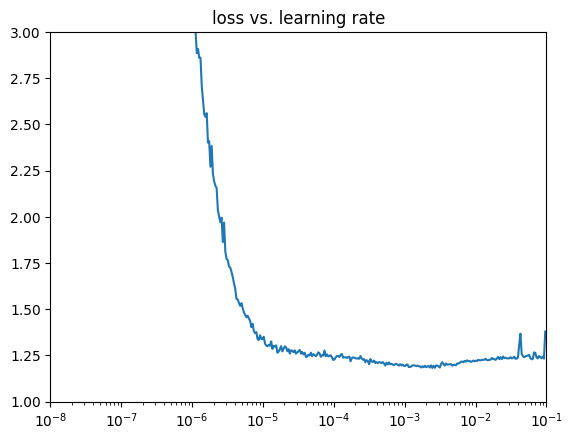

In [44]:
path_to_lr_history = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/training_histories/cutout/ResNeXt101/resnext101lr00_4_classes_run_2024_08_11_04_39_44/history.npy")

history = np.load(path_to_lr_history, allow_pickle=True).item()

plt.semilogx(history["lr"], history["loss"])
plt.title("loss vs. learning rate")
plt.axis([1e-8, 1e-1, 1, 3])

And here I'll go for 10^-3 as well

## Pre Trained